# Machine Learning for Stock Price Prediction

The stock market is known for being volatile, dynamic, and nonlinear. Accurate stock price prediction is extremely challenging because of multiple (macro and micro) factors, such as politics, global economic conditions, unexpected events, a company’s financial performance, and so on. But all of this also means that there’s a lot of data to find patterns in. So, financial analysts, researchers, and data scientists keep exploring analytics techniques to detect stock market trends. This gave rise to the concept of algorithmic trading, which uses automated, pre-programmed trading strategies to execute orders.

In this notebook, we’ll be using both traditional quantitative finance methodology and machine learning algorithms to predict stock movements. We’ll go through the following topics:

- Stock analysis: fundamental vs. technical analysis 
- Stock prices as time-series data and related concepts
- Predicting stock prices with Moving Average techniques
- Introduction to LSTMs 
- Predicting stock prices with an LSTM model
- Final thoughts on new methodologies, such as ESN

## Stock analysis: fundamental analysis vs. technical analysis

Fundamental analysis:
- Evaluates a company’s stock by examining its intrinsic value, including but not limited to tangible assets, financial statements, management effectiveness, strategic initiatives, and consumer behaviors; essentially all the basics of a company.
- Being a relevant indicator for long-term investment, the fundamental analysis relies on both historical and present data to measure revenues, assets, costs, liabilities, and so on.
- Generally speaking, the results from fundamental analysis don’t change with short-term news. 

Technical analysis:
- Analyzes measurable data from stock market activities, such as stock prices, historical returns, and volume of historical trades; i.e. quantitative information that could identify trading signals and capture the movement patterns of the stock market. 
- Technical analysis focuses on historical data and current data just like fundamental analysis, but it’s mainly used for short-term trading purposes.
- Due to its short-term nature, technical analysis results are easily influenced by news.
- Popular technical analysis methodologies include moving average (MA), support and resistance levels, as well as trend lines and channels. 


## Stock prices as time-series data

Despite the volatility, stock prices aren’t just randomly generated numbers. So, they can be analyzed as a sequence of discrete-time data; in other words, time-series observations taken at successive points in time (usually on a daily basis). Time series forecasting (predicting future values based on historical values) applies well to stock forecasting.

Because of the sequential nature of time-series data, we need a way to aggregate this sequence of information. From all the potential techniques, the most intuitive one is MA with the ability to smooth out short-term fluctuations. We’ll discuss more details in the next section.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Model, utils

In [2]:
# %% Train-Test split for time-series
stockprices = pd.read_csv("data.csv", index_col="Date")
stockprices.head()

,Low,High,Close,Open
Date,,,,
1999-11-01,77.37,80.69,77.62,80.00
1999-11-02,77.31,81.69,80.25,78.00
1999-11-03,81.00,83.25,81.50,81.62
1999-11-04,80.62,85.37,83.62,82.06
1999-11-05,84.00,88.37,88.31,84.62


In [3]:
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = stockprices[:train_size][["Close"]]
test = stockprices[train_size:][["Close"]]

train_size: 4363
test_size: 1090


## Evaluation metrics and helper functions 

Since stock prices prediction is essentially a regression problem, the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %) will be our current model evaluation metrics. Both are useful measures of forecast accuracy. 

In [4]:
# Helper functions
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)

#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calculate_perf_metrics(var):
    ### RMSE
    rmse = calculate_rmse(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )
    ### MAPE
    mape = calculate_mape(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )

    return rmse, mape

def plot_stock_trend(var, cur_title, stockprices=stockprices):
    ax = stockprices[["Close", var, "200day"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")


## Predicting stock price with Moving Average (MA) technique

MA is a popular method to smooth out random movements in the stock market. Similar to a sliding window, an MA is an average that moves along the time scale/periods; older data points get dropped as newer data points are added. 

Commonly used periods are 20-day, 50-day, and 200-day MA for short-term, medium-term, and long-term investment respectively. 

Two types of MA are most preferred by financial analysts: Simple MA and Exponential MA.

### Simple MA

SMA, short for Simple Moving Average, calculates the average of a range of stock (closing) prices over a specific number of periods in that range. The formula for SMA is:

$$
SMA = \frac{P_1 +...+P_n}{N}
$$

where $P_n =$ the stock price at time point n, $N =$ the number of time points.

For this exercise of building an SMA model, we’ll use the Python code below to compute the 50-day SMA. We’ll also add a 200-day SMA for good measure.

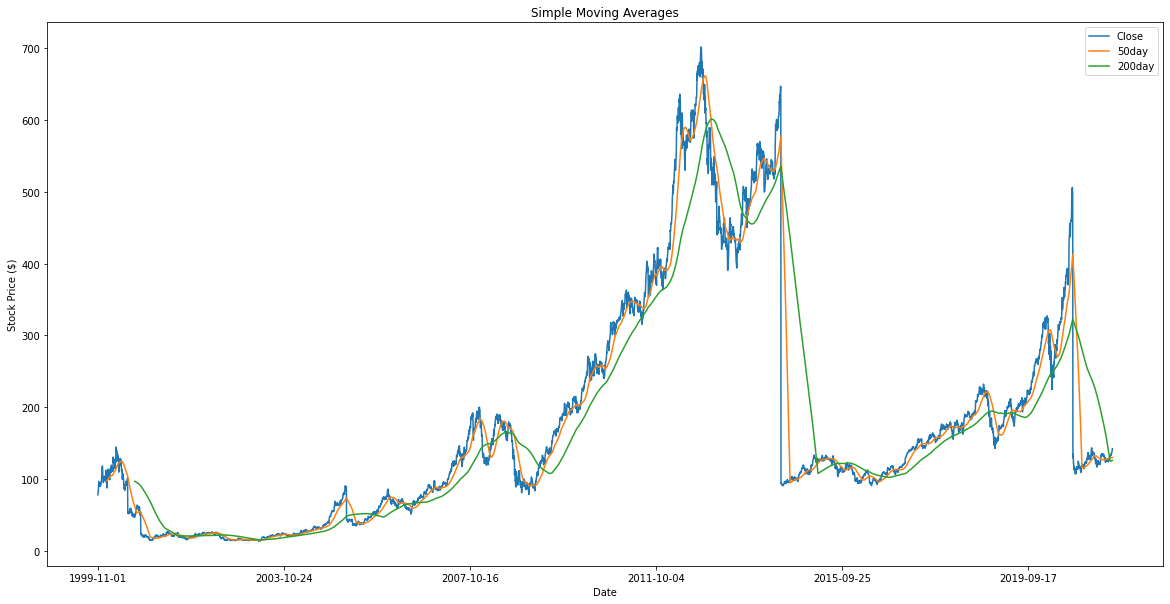

In [5]:
window_size = 50

window_var = f"{window_size}day"

stockprices[window_var] = stockprices["Close"].rolling(window_size).mean()

### Include a 200-day SMA for reference
stockprices["200day"] = stockprices["Close"].rolling(200).mean()

### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title="Simple Moving Averages")
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var)

In [6]:
print(f'RMSE SMA: {rmse_sma}\nMAPE SMA: {mape_sma}')

RMSE SMA: 43.76848947969166
MAPE SMA: 12.529053089133368


## Exponential MA

Different from SMA, which assigns equal weights to all historical data points, EMA, short for Exponential Moving Average, applies higher weights to recent prices, i.e., tail data points of the 50-day MA in our example. The magnitude of the weighting factor depends on the number of time periods. The formula to calculate EMA is:

$$
EMA = P_t + EMA_{t-1}*(1-k)
$$

where $P_t =$ the price at time point t, $EMA_{t-1} =$ EMA at time point $t-1$, $N =$ number of time points in EMA, and weighting factor $k = \frac{2}{N+1}$.

One advantage of the EMA over SMA is that EMA is more responsive to price changes, which makes it useful for short-term trading. Here’s a Python implementation of EMA:

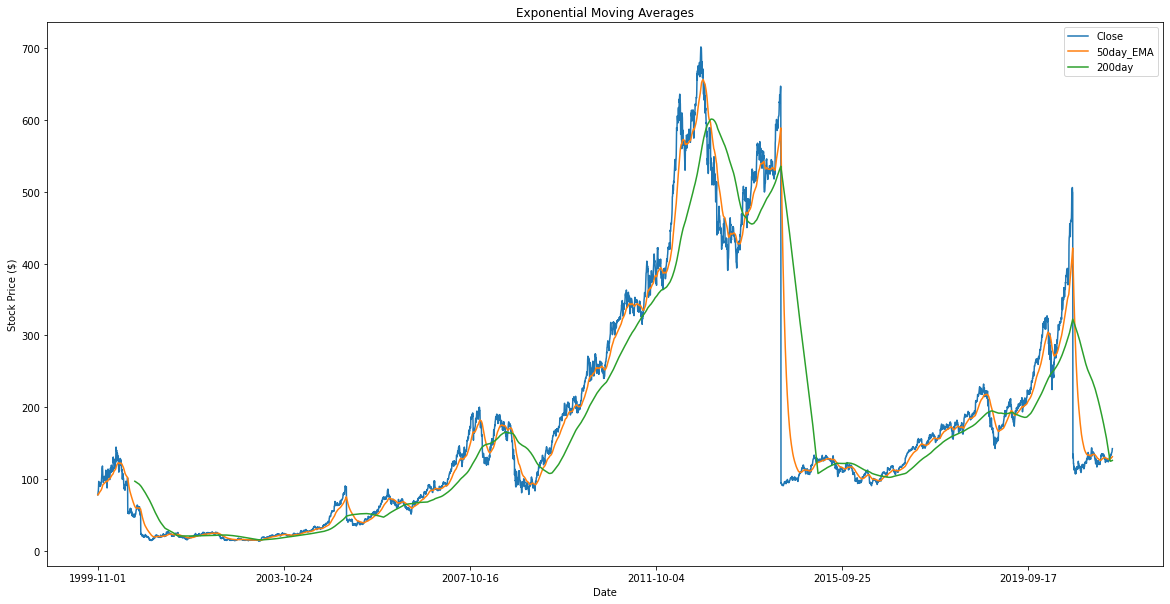

In [7]:
###### Exponential MA
window_ema_var = f"{window_var}_EMA"

# Calculate the 50-day exponentially weighted moving average
stockprices[window_ema_var] = (
    stockprices["Close"].ewm(span=window_size, adjust=False).mean()
)
stockprices["200day"] = stockprices["Close"].rolling(200).mean()

### Plot and performance metrics for EMA model
plot_stock_trend(
    var=window_ema_var, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var)

In [8]:
print(f'RMSE EMA: {rmse_ema}\nMAPE EMA: {mape_ema}')

RMSE EMA: 36.67593508712043
MAPE EMA: 10.71389916884245


Examining the performance metrics, we have RMSE = 36.68, and MAPE = 10.71%, which is an improvement from SMA’s 43.77 and 12.53% for RMSE and MAPE, respectively. The trend chart generated from this EMA model also implies that it outperforms the SMA.

## Introduction to LSTMs for the time-series data

Now, let’s move on to the LSTM model. LSTM, short for Long Short-term Memory, is an extremely powerful algorithm for time series. It can capture historical trend patterns, and predict future values with high accuracy. 

Notation:

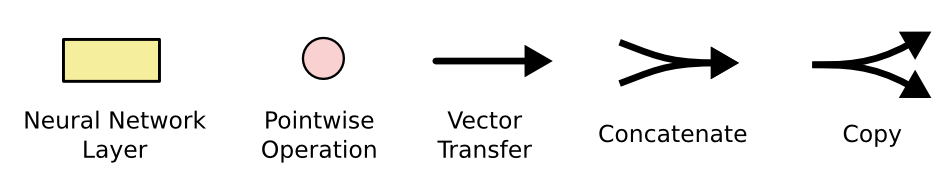

In a nutshell, the key component to understand an LSTM model is the Cell State (Ct), which represents the internal short-term and long-term memories of a cell. 


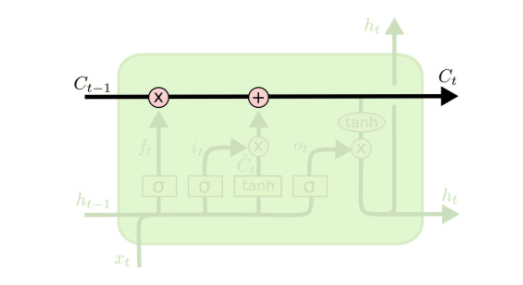

To control and manage the cell state, an LSTM model contains three gates/layers. It’s worth mentioning that the “gates” here can be treated as filters to let information in (being remembered) or out (being forgotten). 

Forget gate: 

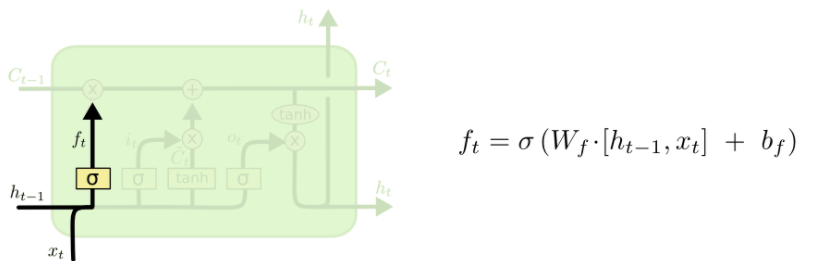

As the name implies, forget gate decides which information to throw away from the current cell state. Mathematically, it applies a sigmoid function to output/returns a value between [0, 1] for each value from the previous cell state (Ct-1); here ‘1’ indicates “completely passing through” whereas ‘0’ indicates “completely filtering out”

Input gate:

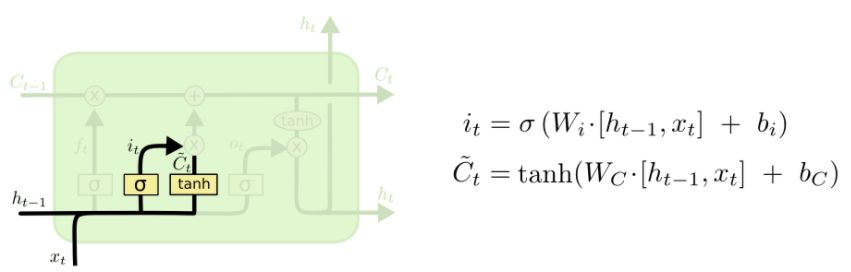

It’s used to choose which new information gets added and stored in the current cell state. In this layer, a sigmoid function is implemented to reduce the values in the input vector (it), and then a tanh function squashes each value between [-1, 1] (Ct). Element-by-element matrix multiplication of it and Ct represents new information that needs to be added to the current cell state. 

In the case of the language model, this is where we’d actually drop the information about the old subject’s gender and add the new information, as we decided in the previous steps.

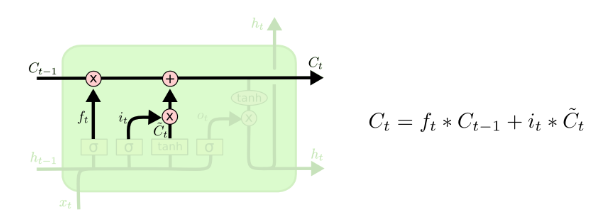

Output gate:

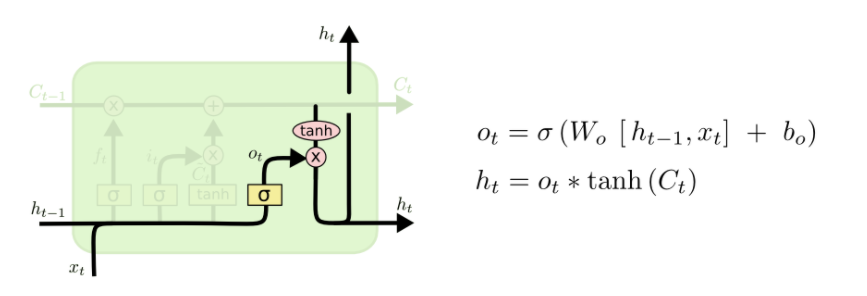

The output gate is implemented to control the output flowing to the next cell state.  Similar to the input gate, an output gate applies a sigmoid and then a tanh function to filter out unwanted information, keeping only what we’ve decided to let through.

For a more detailed understanding of LSTM, you can check out this [document](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).  

Knowing the theory of LSTM, you must be wondering how it does at predicting real-world stock prices. We’ll find out in the next section, by building an LSTM model and comparing its performance against the two technical analysis models: SMA and EMA. 

## Predicting stock prices with an LSTM model

In [9]:
layer_units = 50
optimizer = "adam"
cur_epochs = 15
cur_batch_size = 20

cur_LSTM_args = {
    "units": layer_units,
    "optimizer": optimizer,
    "batch_size": cur_batch_size,
    "epochs": cur_epochs,
}

# Scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[["Close"]])
scaled_data_train = scaled_data[: train.shape[0]]

# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

A couple of notes:

- we use the StandardScaler, rather than the MinMaxScaler as you might have seen before. The reason is that stock prices are ever-changing, and there are no true min or max values. It doesn’t make sense to use the MinMaxScaler, although this choice probably won’t lead to disastrous results at the end of the day;
- stock price data in its raw format can’t be used in an LSTM model directly; we need to transform it using our pre-defined `extract_seqX_outcomeY` function. For instance, to predict the 51st price, this function creates input vectors of 50 data points prior and uses the 51st price as the outcome value.

Moving on, let’s kick off the LSTM modeling process. Specifically, we’re building an LSTM with two hidden layers, and a ‘linear’ activation function upon the output.

In [10]:
### Build a LSTM model

def Run_LSTM(X_train, layer_units=50):
    inp = layers.Input(shape=(X_train.shape[1], 1))

    x = layers.LSTM(units=layer_units, return_sequences=True)(inp)
    x = layers.LSTM(units=layer_units)(x)
    out = layers.Dense(1, activation="linear")(x)
    model = Model(inp, out)

    # Compile the LSTM neural net
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model


model = Run_LSTM(X_train, layer_units=layer_units)

history = model.fit(
    X_train,
    y_train,
    epochs=cur_epochs,
    batch_size=cur_batch_size,
    verbose=1,
    validation_split=0.1,
    shuffle=True
    )

2024-08-22 21:13:50.042519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
195/195 [==============================] - 16s 56ms/step - loss: 0.0633 - val_loss: 0.0017
Epoch 2/15
195/195 [==============================] - 10s 50ms/step - loss: 0.0158 - val_loss: 0.0040
Epoch 3/15
195/195 [==============================] - 11s 54ms/step - loss: 0.0133 - val_loss: 7.1064e-04
Epoch 4/15
195/195 [==============================] - 12s 59ms/step - loss: 0.0092 - val_loss: 6.2227e-04
Epoch 5/15
195/195 [==============================] - 16s 81ms/step - loss: 0.0099 - val_loss: 4.3407e-04
Epoch 6/15
195/195 [==============================] - 11s 55ms/step - loss: 0.0080 - val_loss: 4.1762e-04
Epoch 7/15
195/195 [==============================] - 12s 60ms/step - loss: 0.0069 - val_loss: 3.6573e-04
Epoch 8/15
195/195 [==============================] - 11s 56ms/step - loss: 0.0076 - val_loss: 4.7114e-04
Epoch 9/15
195/195 [==============================] - 11s 56ms/step - loss: 0.0062 - val_loss: 3.3133e-04
Epoch 10/15
195/195 [==============================] -

Once the training completes, we’ll test the model against our hold-out set. 

In [11]:
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price
test["Predictions_lstm"] = predicted_price

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


Time to calculate the performance metrics and log them to Neptune.

RMSE SMA: 12.631287051059541
MAPE SMA: 2.2193701167177537


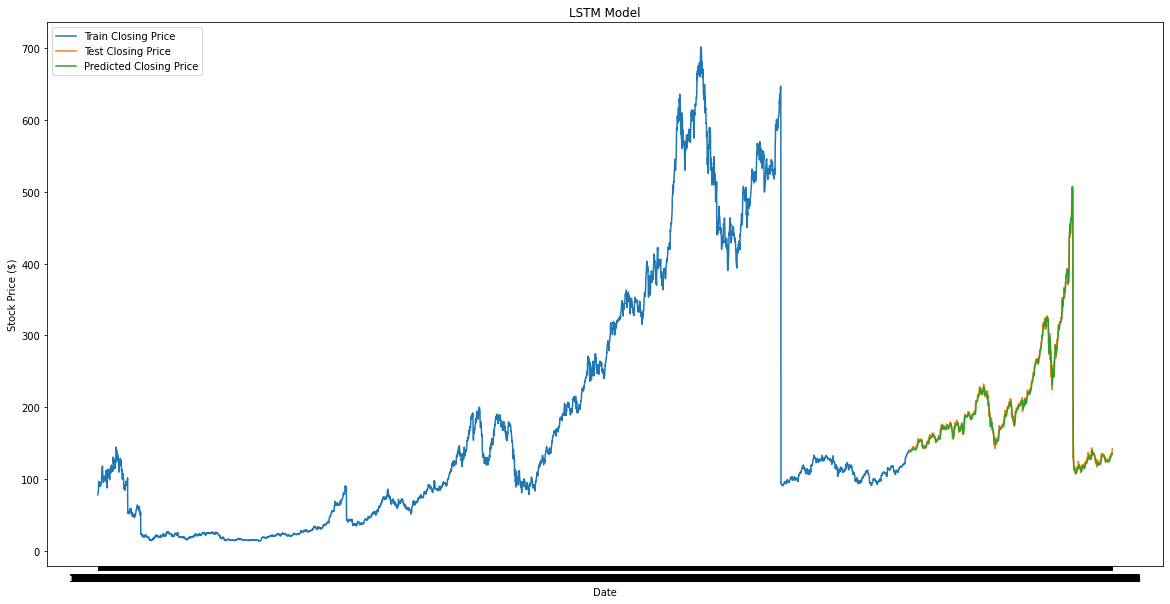

In [12]:
# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculate_mape(np.array(test["Close"]), np.array(test["Predictions_lstm"]))


print(f'RMSE SMA: {rmse_lstm}\nMAPE SMA: {mape_lstm}')

### Plot prediction and true trends and log to Neptune
def plot_stock_trend_lstm(train, test):
    fig = plt.figure(figsize = (20,10))
    plt.plot(np.asarray(train.index), np.asarray(train["Close"]), label = "Train Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Close"]), label = "Test Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Predictions_lstm"]), label = "Predicted Closing Price")
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")

plot_stock_trend_lstm(train, test)

It’s amazing to see that our LSTM model achieved an RMSE = 12.58 and MAPE = 2%; a tremendous improvement from the SMA and EMA models! The trend chart shows a near-perfect overlay of the predicted and actual closing price for our testing set.

## Final thoughts on new methodologies

We’ve seen the advantage of LSTMs in the example of predicting Apple stock prices compared to traditional MA models. Be careful about making generalizations to other stocks, because, unlike other stationary time series, stock market data is less-to-none seasonal and more chaotic. 

In our example, Apple, as one of the biggest tech giants, has not only established a mature business model and management, its sales figures also benefit from the release of innovative products or services. Both contribute to the lower implied volatility of Apple stock, making the predictions relatively easier for the LSTM model in contrast to different, high-volatility stocks. 

In addition, it would be interesting to incorporate sentiment analysis on news and social media regarding the stock market in general, as well as a given stock of interest. Another promising approach for better stock price predictions is the hybrid model, where we add MA predictions as input vectors to the LSTM model. You might want to explore different methodologies, too.

end...